# Movie recommendation systeme

source : https://www.kaggle.com/datasets/victorsoeiro/netflix-tv-shows-and-movies?select=titles.csv , Data collected from JustWatch. 

In [655]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import ast

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.ensemble import RandomForestRegressor

## Step 1 : Files importation

In [657]:
# Read the CSV file
df = pd.read_csv('input/titles.csv')

In [659]:
df.head(5)

id                                title   type  \
0  ts300399  Five Came Back: The Reference Films   SHOW   
1   tm84618                          Taxi Driver  MOVIE   
2  tm154986                          Deliverance  MOVIE   
3  tm127384      Monty Python and the Holy Grail  MOVIE   
4  tm120801                      The Dirty Dozen  MOVIE   

                                         description  release_year  \
0  This collection includes 12 World War II-era p...          1945   
1  A mentally unstable Vietnam War veteran works ...          1976   
2  Intent on seeing the Cahulawassee River before...          1972   
3  King Arthur, accompanied by his squire, recrui...          1975   
4  12 American military prisoners in World War II...          1967   

  age_certification  runtime                                       genres  \
0             TV-MA       51                            ['documentation']   
1                 R      114                           ['drama', 'crime']   
2                 R      109  ['drama', 'action', 'thriller', 'european']   
3                PG       91              ['fantasy', 'action', 'comedy']   
4               NaN      150                            ['war', 'action']   

  production_countries  seasons    imdb_id  imdb_score  imdb_votes  \
0               ['US']      1.0        NaN         NaN         NaN   
1               ['US']      NaN  tt0075314         8.2    808582.0   
2               ['US']      NaN  tt0068473         7.7    107673.0   
3               ['GB']      NaN  tt0071853         8.2    534486.0   
4         ['GB', 'US']      NaN  tt0061578         7.7     72662.0   

   tmdb_popularity  tmdb_score  
0            0.600         NaN  
1           40.965       8.179  
2           10.010       7.300  
3           15.461       7.811  
4           20.398       7.600

In [661]:
len(df)

5850

## Step 2 : Data formatting

In [663]:
# Filter out TV shows and unecessary columns
df = df[df['type']=='MOVIE'].drop(['type','seasons','age_certification','imdb_id'], axis=1).reset_index(drop=True)

In [665]:
df.head(3)

id                            title  \
0   tm84618                      Taxi Driver   
1  tm154986                      Deliverance   
2  tm127384  Monty Python and the Holy Grail   

                                         description  release_year  runtime  \
0  A mentally unstable Vietnam War veteran works ...          1976      114   
1  Intent on seeing the Cahulawassee River before...          1972      109   
2  King Arthur, accompanied by his squire, recrui...          1975       91   

                                        genres production_countries  \
0                           ['drama', 'crime']               ['US']   
1  ['drama', 'action', 'thriller', 'european']               ['US']   
2              ['fantasy', 'action', 'comedy']               ['GB']   

   imdb_score  imdb_votes  tmdb_popularity  tmdb_score  
0         8.2    808582.0           40.965       8.179  
1         7.7    107673.0           10.010       7.300  
2         8.2    534486.0           15.461       7.811

In [667]:
len(df)

3744

In [669]:
#Extract genres
def extract_genres(genre_str):
    genre_list = ast.literal_eval(genre_str)
    first_genre = genre_list[0] if len(genre_list) > 0 else np.nan
    second_genre = genre_list[1] if len(genre_list) > 1 else "no_second-genre"
    return first_genre, second_genre

In [671]:
df[['first_genre', 'second_genre']] = df['genres'].apply(lambda x: pd.Series(extract_genres(x)))

In [673]:
df = df.drop('genres', axis=1)

In [675]:
#Extract main production country
def extract_country(country_str):
    country_list = ast.literal_eval(country_str)
    country = country_list[0] if len(country_list) > 0 else np.nan
    return country

In [677]:
df["country"] = df["production_countries"].apply(extract_country)

In [679]:
df = df.drop('production_countries', axis=1)

## Step 3 : Missing values

### General

In [681]:
def percent_missing(df):
    per_nan = 100*df.isnull().sum() /len(df)
    per_nan = per_nan[per_nan >0].sort_values()    
    return per_nan

In [683]:
percent_missing(df)

title              0.026709
description        0.240385
first_genre        0.908120
tmdb_popularity    1.655983
country            4.300214
tmdb_score         5.208333
imdb_score         8.413462
imdb_votes         8.840812
dtype: float64

In [685]:
df = df.dropna(subset=['title', 'description'])

In [687]:
missing_value_line = df[df.isnull().sum(axis=1) >3]

In [689]:
df = df.drop(missing_value_line.index)

In [691]:
percent_missing(df)

first_genre        0.350783
tmdb_popularity    1.241230
country            3.642742
tmdb_score         4.533189
imdb_score         7.609282
imdb_votes         7.987048
dtype: float64

### tmdb_score and imdb_score

<Axes: xlabel='tmdb_score', ylabel='imdb_score'>

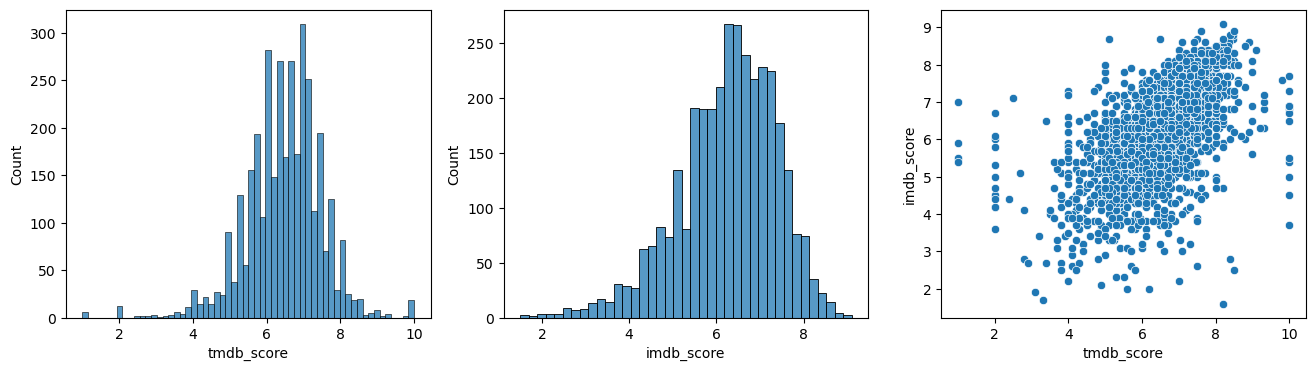

In [693]:
#plot distribution and corelation
fig,axes = plt.subplots(nrows=1,ncols=3, figsize=(16,4))
sns.histplot(df.tmdb_score, ax = axes[0])
sns.histplot(df.imdb_score, ax = axes[1])
sns.scatterplot(data=df, x ='tmdb_score',y='imdb_score')

In [695]:
# Filling missing values with each other
df['tmdb_score'] = df['tmdb_score'].fillna(df['imdb_score'])
df['imdb_score'] = df['imdb_score'].fillna(df['tmdb_score'])

In [697]:
# Drop down if the 2 are empty
drop_line = df[(df['imdb_score'].isnull())&(df['tmdb_score'].isnull())]
df = df.drop(drop_line.index)

In [699]:
percent_missing(df)

first_genre        0.353453
tmdb_popularity    1.250680
country            3.670473
imdb_votes         7.286569
dtype: float64

### genre missing values

In [701]:
missing_first_genre_indices = df[df['first_genre'].isnull()].index

In [703]:
df.loc[missing_first_genre_indices[0], 'first_genre'] = 'drama'
df.loc[missing_first_genre_indices[1], 'first_genre'] = 'drama'
df.loc[missing_first_genre_indices[2], 'first_genre'] = 'animation'
df.loc[missing_first_genre_indices[3], 'first_genre'] = 'animation'
df.loc[missing_first_genre_indices[4], 'first_genre'] = 'animation'
df.loc[missing_first_genre_indices[5], 'first_genre'] = 'thriller'
df.loc[missing_first_genre_indices[6], 'first_genre'] = 'comedy'
df.loc[missing_first_genre_indices[8], 'first_genre'] = 'documentation'
df.loc[missing_first_genre_indices[9], 'first_genre'] = 'documentation'
df.loc[missing_first_genre_indices[10], 'first_genre'] = 'documentation'
df.loc[missing_first_genre_indices[11], 'first_genre'] = 'documentation'
df.loc[missing_first_genre_indices[12], 'first_genre'] = 'documentation'

In [705]:
df = df.dropna(subset=['first_genre'])

In [707]:
percent_missing(df)

tmdb_popularity    1.251020
country            3.671471
imdb_votes         7.261354
dtype: float64

### Country missing values

In [709]:
df['country'].fillna('unknown_country', inplace=True)

In [711]:
percent_missing(df)

tmdb_popularity    1.251020
imdb_votes         7.261354
dtype: float64

### imdb_votes and tmdb_popularity missing values

In [713]:
len(df[df['imdb_votes'].isnull()])

267

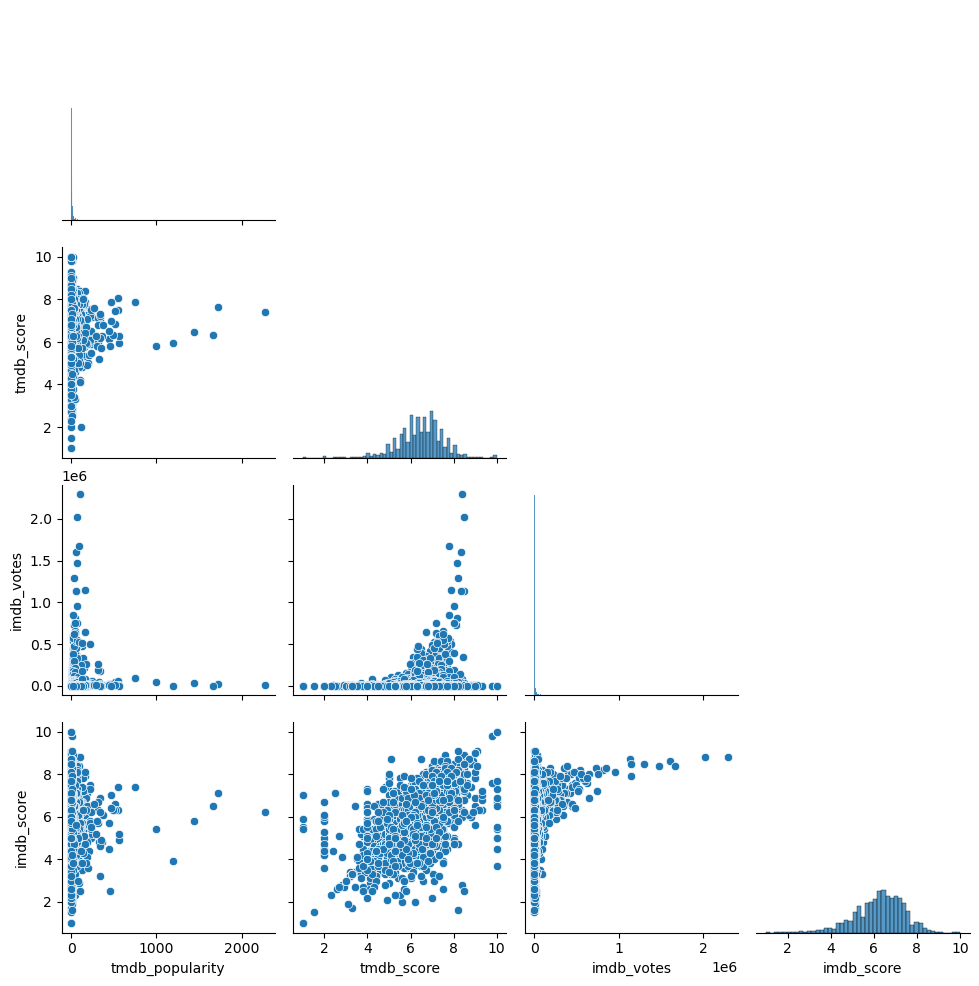

In [715]:
# pairplot numerical value tmdb et imdb
subset = df[['tmdb_popularity', 'tmdb_score', 'imdb_votes', 'imdb_score']]
sns.pairplot(subset, corner=True)

In [721]:
# prediction with machine learning
def predict_missing_values(df, target_column):
    df_model = df[["release_year", "runtime", "first_genre", "country", "imdb_score", "tmdb_score", target_column]]
    df_model_obj = df_model[['first_genre', 'country']]
    df_model_dummies = pd.get_dummies(df_model_obj, drop_first=True)
    df_model_num = df_model.select_dtypes('number')
    df_model = pd.concat([df_model_num, df_model_dummies], axis=1)

    train_data = df_model.dropna(subset=[target_column])
    test_data = df_model[df_model[target_column].isnull()]
    X_train = train_data.drop(target_column, axis=1)
    y_train = train_data[target_column]

    model = RandomForestRegressor(n_estimators=100, random_state=0)
    model.fit(X_train, y_train)

    X_test = test_data.drop(target_column, axis=1)
    predictions = model.predict(X_test)

    df.loc[df[target_column].isnull(), target_column] = predictions

In [723]:
predict_missing_values(df, 'tmdb_popularity')
df.tmdb_popularity.describe()

count    3677.000000
mean       20.414589
std        78.108725
min         0.055091
25%         2.565000
50%         5.960000
75%        14.843000
max      2274.044000
Name: tmdb_popularity, dtype: float64


In [725]:
predict_missing_values(df, 'imdb_votes')
df.imdb_votes.describe()

count    3.677000e+03
mean     2.726892e+04
std      1.098950e+05
min      5.000000e+00
25%      6.100000e+02
50%      2.594000e+03
75%      1.169300e+04
max      2.294231e+06
Name: imdb_votes, dtype: float64

## Keywords Extractions

ref article : https://www.analyticsvidhya.com/blog/2022/01/four-of-the-easiest-and-most-effective-methods-of-keyword-extraction-from-a-single-text-using-python/  
Yake: Campos, Ricardo, et al. “YAKE! Keyword extraction from single documents using multiple local features.” Information Sciences 509 (2020): 257-289.

In [ ]:
pip install git+https://github.com/LIAAD/yake

In [570]:
import yake

In [578]:
def extract_keywords(title, text):
    combined_text = title + " " + text
    kw_extractor = yake.KeywordExtractor(top=3, stopwords=None, n=1)
    keywords = kw_extractor.extract_keywords(combined_text)
    # Extraire seulement les mots-clés, ignorer les scores
    return [kw for kw, v in keywords]

In [580]:
df['keywords'] = df.apply(lambda row: extract_keywords(row['title'], row['description']), axis=1)

In [598]:
df['keywords'].info()

<class 'pandas.core.series.Series'>
Index: 3677 entries, 0 to 3743
Series name: keywords
Non-Null Count  Dtype 
--------------  ----- 
3677 non-null   object
dtypes: object(1)
memory usage: 186.5+ KB


In [612]:
def formatting_keywords(keywords):
    #keywords_list = ast.literal_eval(keywords_str)
    first_keyword = keywords[0] if len(keywords) > 0 else np.nan
    second_keyword = keywords[1] if len(keywords) > 1 else np.nan
    third_keyword = keywords[2] if len(keywords) > 2 else 'no_third_keywords'
    return first_keyword, second_keyword,third_keyword

In [614]:
df[['first_keyword', 'second_keyword', 'third_keyword']] = df['keywords'].apply(lambda x: pd.Series(formatting_keywords(x)))

In [616]:
df.head(5)

title  \
0                      Taxi Driver   
1                      Deliverance   
2  Monty Python and the Holy Grail   
3                  The Dirty Dozen   
4                    Life of Brian   

                                         description  release_year  runtime  \
0  A mentally unstable Vietnam War veteran works ...          1976      114   
1  Intent on seeing the Cahulawassee River before...          1972      109   
2  King Arthur, accompanied by his squire, recrui...          1975       91   
3  12 American military prisoners in World War II...          1967      150   
4  Brian Cohen is an average young Jewish man, bu...          1979       94   

   imdb_score  imdb_votes  tmdb_popularity  tmdb_score first_genre  \
0         8.2    808582.0           40.965       8.179       drama   
1         7.7    107673.0           10.010       7.300       drama   
2         8.2    534486.0           15.461       7.811     fantasy   
3         7.7     72662.0           20.398       7.600         war   
4         8.0    395024.0           17.770       7.800      comedy   

      second_genre country                       keywords first_keyword  \
0            crime      US         [Driver, Vietnam, War]        Driver   
1           action      US  [Intent, Cahulawassee, River]        Intent   
2           action      GB           [Sir, Arthur, Table]           Sir   
3           action      GB       [Dozen, American, Dirty]         Dozen   
4  no_second-genre      GB        [Messiah, Brian, Cohen]       Messiah   

  second_keyword third_keyword  
0        Vietnam           War  
1   Cahulawassee         River  
2         Arthur         Table  
3       American         Dirty  
4          Brian         Cohen

In [618]:
percent_missing(df)

Series([], dtype: float64)

In [622]:
df = df.drop('keywords', axis=1)
df = df.reset_index(drop=True)

## Common score

In [820]:
df['tmdb_popularity_norm'] = (df['tmdb_popularity'] - df['tmdb_popularity'].min()) / (df['tmdb_popularity'].max() - df['tmdb_popularity'].min())
df['imdb_votes_norm'] = (df['imdb_votes'] - df['imdb_votes'].min()) / (df['imdb_votes'].max() - df['imdb_votes'].min())

In [826]:
df['weighted_imdb_score'] = df['imdb_score'] * df['imdb_votes_norm']
df['weighted_tmdb_score'] = df['tmdb_score'] * df['tmdb_popularity_norm']

In [830]:
df['my_rating'] = (df['weighted_imdb_score'] + df['weighted_tmdb_score']) / (df['imdb_votes_norm'] + df['tmdb_popularity_norm'])

In [836]:
df = df[["id","title","description","release_year","runtime","first_genre","second_genre","country","my_rating"]]

In [838]:
df.head(3)

id                            title  \
0   tm84618                      Taxi Driver   
1  tm154986                      Deliverance   
2  tm127384  Monty Python and the Holy Grail   

                                         description  release_year  runtime  \
0  A mentally unstable Vietnam War veteran works ...          1976      114   
1  Intent on seeing the Cahulawassee River before...          1972      109   
2  King Arthur, accompanied by his squire, recrui...          1975       91   

  first_genre second_genre country  my_rating  
0       drama        crime      US   8.198980  
1       drama       action      US   7.665871  
2     fantasy       action      GB   8.189007

<Axes: xlabel='my_rating', ylabel='Count'>

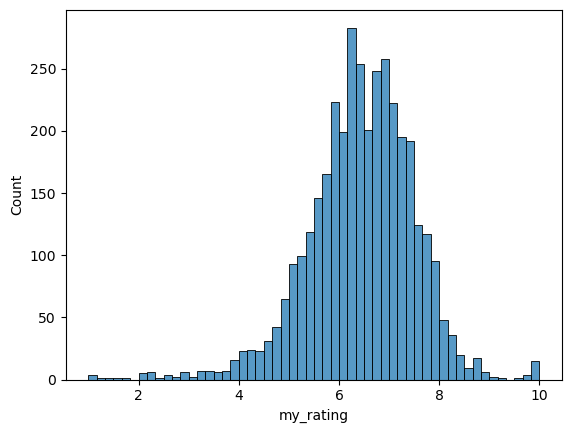

In [840]:
sns.histplot(df, x='my_rating')

## Save

In [842]:
df.to_csv("movie_recom_pandas.csv", index=False)

In [35]:
df_combine_describe = df_combined.describe().compute()
df_combine_describe

Rating      Movie_Id          Year
count  9.876119e+07  9.876119e+07  9.876119e+07
mean   3.610411e+00  2.216522e+03  1.990519e+03
std    1.081735e+00  1.269288e+03  1.663832e+01
min    1.000000e+00  3.000000e+00  1.915000e+03
25%    3.000000e+00  1.149000e+03  1.994000e+03
50%    4.000000e+00  2.193000e+03  2.000000e+03
75%    5.000000e+00  3.329000e+03  2.003000e+03
max    5.000000e+00  4.709000e+03  2.005000e+03

In [81]:
#distribution des notes
rating_counts = df_combined['Rating'].value_counts().compute()
rating_counts_df = rating_counts.reset_index()
rating_counts_df.columns = ['Rating', 'Count']
# Calculer les pourcentages
total_count = rating_counts_df['Count'].sum()
rating_counts_df['Percentage'] = (rating_counts_df['Count'] / total_count) * 100
# Trier les valeurs pour que les barres correspondent
rating_counts_df = rating_counts_df.sort_values('Rating')

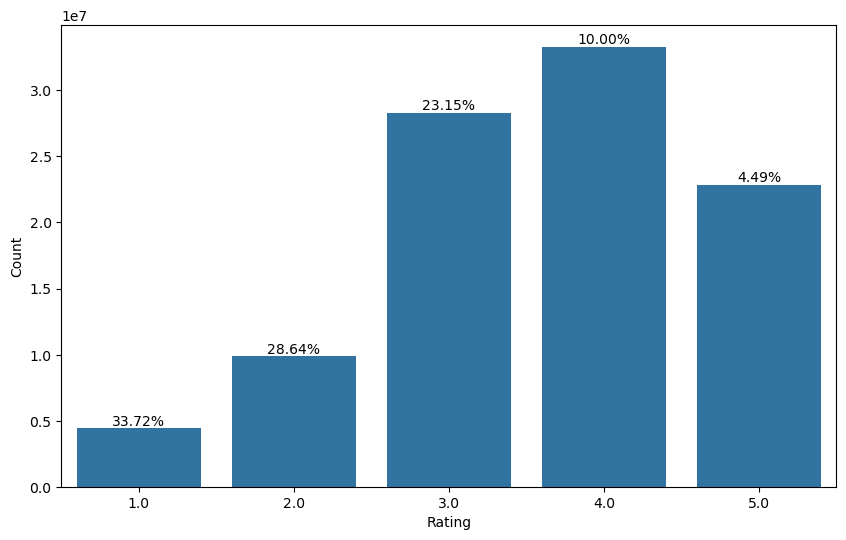

In [79]:
# Tracer un barplot avec les données agrégées
plt.figure(figsize=(10, 6))
barplot = sns.barplot(data=rating_counts_df, x='Rating', y='Count')

# Ajouter les pourcentages sur chaque barre
for index, row in rating_counts_df.iterrows():
    bar = barplot.patches[index]
    barplot.text(bar.get_x() + bar.get_width() / 2, bar.get_height(),
        f"{row['Percentage']:.2f}%",
        color='black',
        ha="center",
        va="bottom"
    )


In [477]:
top_movies = df_combined.groupby('Title')['Rating'].mean().nlargest(10).compute()
top_movies

Title
Damn the Defiant                                 4.645549
Night of the Hunted                              4.568930
Tank Girl                                        4.548398
Irreversible                                     4.531854
Dirty Tiger                                      4.500427
Boys Life 4: Four Play                           4.488026
Tales of Terror                                  4.484326
The Simpsons: Season 6                           4.483073
Walt Disney's Timeless Tales: Vol. 2             4.462211
Lord of the Rings: The Fellowship of the Ring    4.442368
Name: Rating, dtype: float64

In [481]:
ratings_count = df_combined.groupby('Title')['Rating'].count().nlargest(10).compute()
ratings_count

Title
Logan's Run                    304284
Cadfael: The Potter's Field    257782
Braveheart                     232480
The Testament of Dr. Mabuse    223819
The Lord of the Rings          222497
Kickboxer                      215799
The Toy                        215000
Sex and the Teenage Mind       207776
Two's Company: Series 1        205831
About Schmidt                  202132
Name: Rating, dtype: int64

## Recommendation : search for similarity

In [807]:
def recommend_movies(user_preferences, df):
    # fetch user input
    favorite_genre = user_preferences['favorite_genres']
    likes_old_movies = user_preferences['likes_old_movies']
    available_time = user_preferences['preferred_duration']
    
    # filter genre
    genre_filter = df['first_genre'].isin(favorite_genre) | df['second_genre'].isin(favorite_genre)
    recommended_movies = df[genre_filter]
    
    # filter date release
    if likes_old_movies == 'avant 2000': 
        recommended_movies = recommended_movies[recommended_movies['release_year'] < 2000]
    elif likes_old_movies == 'apres 2000': 
        recommended_movies = recommended_movies[recommended_movies['release_year'] >= 2000]
        
    # filter available time
    if available_time == '60-90' :
        recommended_movies = recommended_movies[recommended_movies['runtime'] <= 90]
    elif available_time == '90-120':
        recommended_movies = recommended_movies[(recommended_movies['runtime'] > 90) & (recommended_movies['runtime'] <= 120)]
    else:
        recommended_movies = recommended_movies[recommended_movies['runtime'] > 120]
        
    # si aucun film trouvé : film similaire
    if recommended_movies.empty:
        print("recherche de film similaire")
        
    return recommended_movies

In [813]:
# Exemple de préférences utilisateur
user_preferences = {
    'favorite_genres': ['action'],
    'likes_old_movies': 'indifferent',
    'preferred_duration': '90-120'
}

In [815]:
recommended_movies = recommend_movies(user_preferences, df)

In [817]:
recommended_movies

id                                  title  \
1      tm154986                            Deliverance   
2      tm127384        Monty Python and the Holy Grail   
5       tm14873                            Dirty Harry   
7       tm98978                        The Blue Lagoon   
9       tm67378                      The Professionals   
...         ...                                    ...   
3553  tm1000296                 New Gods: Nezha Reborn   
3635  tm1068632                             Bartkowiak   
3642   tm996996  The Misadventures of Hedi and Cokeman   
3678  tm1098060                         Shadow Parties   
3697   tm986017                  Gatao: The Last Stray   

                                            description  release_year  \
1     Intent on seeing the Cahulawassee River before...          1972   
2     King Arthur, accompanied by his squire, recrui...          1975   
5     When a madman dubbed 'Scorpio' terrorizes San ...          1971   
7     Two small children and a ship's cook survive a...          1980   
9     An arrogant Texas millionaire hires four adven...          1966   
...                                                 ...           ...   
3553  Three thousand years ago, the world was in tur...          2021   
3635  After his brother dies in a car crash, a disgr...          2021   
3642  In Paris, two dysfunctional dealers use family...          2021   
3678  A family faces destruction in a long-running c...          2021   
3697  A Qing encounters the photographer Xiao Qi at ...          2021   

      runtime  imdb_score  imdb_votes  tmdb_popularity  tmdb_score  \
1         109         7.7    107673.0           10.010       7.300   
2          91         8.2    534486.0           15.461       7.811   
5         102         7.7    155051.0           12.817       7.500   
7         104         5.8     69844.0           50.324       6.156   
9         117         7.3     16446.0           13.123       7.100   
...       ...         ...         ...              ...         ...   
3553      116         6.8      3150.0            3.078       8.200   
3635       91         5.1      1205.0           62.624       6.200   
3642       99         4.4       641.0           19.908       4.400   
3678      116         6.2         9.0            1.286       6.200   
3697      120         5.9       266.0            3.141       4.900   

     first_genre second_genre country  
1          drama       action      US  
2        fantasy       action      GB  
5       thriller       action      US  
7        romance       action      US  
9        western       action      US  
...          ...          ...     ...  
3553   animation       action      CN  
3635      action     thriller      PL  
3642      action        crime      FR  
3678      action        drama      NG  
3697      action        crime      TW  

[227 rows x 12 columns]